In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Loading and Cleaning Up Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/MIT/MIT Fall 2023/6.3950/education_data_cleaned_rows.csv')

In [ ]:
def clean_data(df, target_var, max_data_year):
    # remove unknown target vars
    df = df[df[target_var] != -9]
    df = df[df[target_var] != -1]

    # dropping columns with data after max_data_year besides target var
    remove_vars = []
    for i in range(max_data_year+1, 8):
        remove_vars.append("R" + str(i))
        remove_vars.append("F" + str(i))
        remove_vars.append("C" + str(i))
        remove_vars.append("P" + str(i))
        remove_vars.append("T" + str(i))

    for col in df.columns:
        if any(char in col for char in remove_vars):
            if col != target_var:
                df.drop(col, axis=1, inplace=True)
                print('dropping ' + col)
            else:
                print('not dropping ' + target_var)


    # replace -1/-9/nan with mean value for non-categorical columns and 0 for categorical columns
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        invalid = (df[col] < 0 ) | (df[col].isnull())
        if any(var in col for var in categorical_features):
            df.loc[invalid, col] = -1
        else:
            mean = df[df[col] >= 0][col].mean()
            df.loc[invalid, col] = mean

          # standardizing data
            std = df[col].std()
            if col != target_var:
                df[col] = (df[col] - mean) / std
    return df

In [ ]:
# manually identified using codebook
categorical_features = {'RACE', 'GENDER', 'URBAN', 'REGION', 'CS_TYPE2', "SPECS", "CLASS", "EMP", "RACE", "HISP", "IND",
               "ASN", "BLCK", "PACI", "WHT", "MT1R", "OCC", "NOW", "P1PRIMNW", "P1CENTER", "P1DISABL",
               "LANG", "P1HMLTOM", "P1HDLTOD", "P1HMOM", "P1HDAD", "P1HFAMIL", "P1HPARNT", "TYP", "P2MARSTA",
               "WKCAREPK", "P1PRIMPK", "WKPOV_R", "P2FSSTAT", "W1POVRTY"}

def one_hot_encode(df, feature_to_encode):
    one_hot_encoded = pd.get_dummies(df[feature_to_encode], prefix=feature_to_encode)
    df.drop(feature_to_encode, axis=1, inplace=True)
    df = pd.concat([df, one_hot_encoded], axis=1)
    return df

In [ ]:
def process_df(df, target_var, max_year_with_features):
    # cleaning up df
    df = clean_data(df, target_var, max_year_with_features)

    # one-hot encoding categorical features
    features_to_encode = [col for col in df.columns if any(var in col for var in categorical_features)]
    for feature in features_to_encode:
        df = one_hot_encode(df, feature)
    return df

### Training and Evaluating Regression Model

In [ ]:
max_year_with_features = 5
df_reading_reg = process_df(df, "C7R4RSCL", max_year_with_features)
df_math_reg = process_df(df, "C7R4MSCL", max_year_with_features)

dropping R6AGE
dropping R7AGE
dropping R7URBAN
dropping R7REGION
dropping R6URBAN
dropping R6REGION
dropping F7SPECS
dropping F6SPECS
dropping C6R4RSCL
dropping C6R4MSCL
dropping C6R4MPF
not dropping C7R4RSCL
dropping C7R4MSCL
dropping C7R4MPF
dropping T6ARSLIT
dropping T6ARSMAT
dropping R6AGE
dropping R7AGE
dropping R7URBAN
dropping R7REGION
dropping R6URBAN
dropping R6REGION
dropping F7SPECS
dropping F6SPECS
dropping C6R4RSCL
dropping C6R4MSCL
dropping C6R4MPF
dropping C7R4RSCL
not dropping C7R4MSCL
dropping C7R4MPF
dropping T6ARSLIT
dropping T6ARSMAT


<Axes: ylabel='Frequency'>

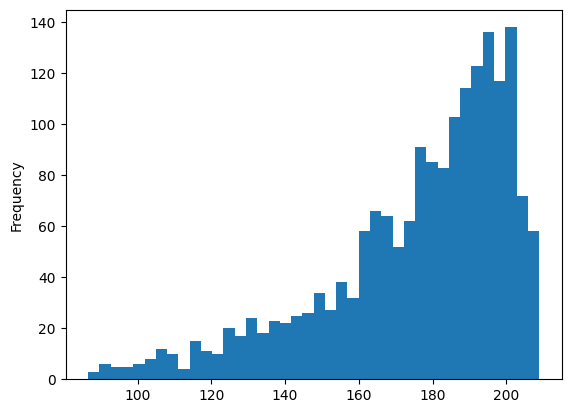

In [ ]:
df_reading_reg['C7R4RSCL'].plot.hist(bins=40)

<Axes: ylabel='Frequency'>

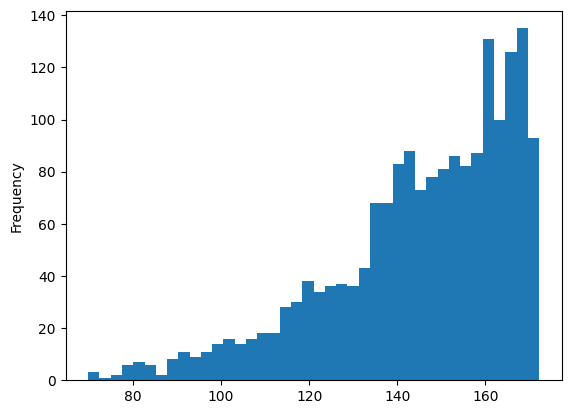

In [ ]:
df_math_reg['C7R4MSCL'].plot.hist(bins=40)

In [ ]:
import re
def select_predictors(feature_cols):
      cols_to_remove = []
      for col_name in feature_cols:
        if re.match(r"C\d[RS].*", col_name) or re.match(r"T\d.*", col_name):
          cols_to_remove.append(col_name)
          # print("excluding ", col_name)
        # else:
          # print("keeping ", col_name)
      for col_name in cols_to_remove:
        feature_cols.remove(col_name)
      return feature_cols

def train_and_eval_regression_model(df, target_var, model, model_name, remove_other_scores = False, attributes = {}, select_from_model = False, max_features = 100):
    # "independent" variables
    feature_cols = list(df.columns.values)
    feature_cols.remove(target_var)

    if remove_other_scores:
      feature_cols = select_predictors(feature_cols)

    X = df[feature_cols] # Features
    y = df[target_var] # Target variable

    # Split dataset into training set and test set
    # 70% training and 30% test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

    for attribute in attributes:
        y_test = y_test[X_test[attribute] == attributes[attribute]]
        X_test = X_test[X_test[attribute] == attributes[attribute]]
        print('Only testing on those with attribute ', attribute)

    print('Num testing samples', len(y_test))

    if select_from_model:
        model = Pipeline([
        ('feature_selection', SelectFromModel(RandomForestRegressor(), max_features = max_features)),
        ('regressor', RandomForestRegressor())
        ])

    reg = model.fit(X_train, y_train)
    y_pred = reg.predict(X_test)

    # compare training and test accuracy
    print("Training R^2 Score: " + str(model.score(X_train, y_train)))
    print("Test R^2 Score: " + str(model.score(X_test, y_test)))

    # Calculate the Mean Squared Error
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error (MSE): {mse:.4f}")

    # save model
    pickle.dump(model, open(model_name + '_model.sav', 'wb'))

    return model, mse

### Training Models Using All Features [Models are not optimized here; this is just for experimentation]

In [ ]:
rf_reg = RandomForestRegressor(n_estimators=50, max_depth=30, max_leaf_nodes=120, max_features=100)
trained_rf_reading_reg, rf_reading_mse = train_and_eval_regression_model(df_reading_reg, "C7R4RSCL", rf_reg, "reading_rf")
trained_rf_math_reg, rf_math_mse = train_and_eval_regression_model(df_math_reg, "C7R4MSCL", rf_reg, "math_rf")

Num testing samples 547
Training R^2 Score: 0.8930369192281673
Test R^2 Score: 0.548671435835901
Mean Squared Error (MSE): 307.0364
Num testing samples 547
Training R^2 Score: 0.9105728848306983
Test R^2 Score: 0.683689082286444
Mean Squared Error (MSE): 138.1036


In [ ]:
xgb_regressor = xgb.XGBRegressor(n_estimators=50, max_depth = 30)
trained_xgb_reading_model, xgb_reading_mse = train_and_eval_regression_model(df_reading_reg, "C7R4RSCL", xgb_regressor, "reading_xgb")
trained_xgb_math_model, xgb_math_mse = train_and_eval_regression_model(df_math_reg, "C7R4MSCL", xgb_regressor, "math_xgb")

Num testing samples 547
Training R^2 Score: 0.9999999979422283
Test R^2 Score: 0.4563750060546171
Mean Squared Error (MSE): 369.8252
Num testing samples 547
Training R^2 Score: 0.9999999971656648
Test R^2 Score: 0.6397060490471298
Mean Squared Error (MSE): 157.3069


In [ ]:
dt_regressor = DecisionTreeRegressor(max_depth=30)
trained_tree_reading_model, dt_reading_mse = train_and_eval_regression_model(df_reading_reg, "C7R4RSCL", dt_regressor, "reading_tree")
trained_tree_math_model, dt_math_mse = train_and_eval_regression_model(df_math_reg, "C7R4MSCL", dt_regressor, "math_tree")

Num testing samples 547
Training R^2 Score: 1.0
Test R^2 Score: 0.20285820155242984
Mean Squared Error (MSE): 542.2913
Num testing samples 547
Training R^2 Score: 1.0
Test R^2 Score: 0.4420819102612352
Mean Squared Error (MSE): 243.5911


In [ ]:
mlp_regressor = MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=50, random_state=1)
trained_mlp_reading_model, mlp_reading_mse = train_and_eval_regression_model(df_reading_reg, "C7R4RSCL", mlp_regressor, "reading_mlp")
trained_mlp_math_model, mlp_math_mse = train_and_eval_regression_model(df_math_reg, "C7R4MSCL", mlp_regressor, "math_mlp")

Num testing samples 547


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Training R^2 Score: 0.6582520576716494
Test R^2 Score: 0.5401123911832437
Mean Squared Error (MSE): 312.8591
Num testing samples 547
Training R^2 Score: 0.7118065872005577
Test R^2 Score: 0.6235213804776212
Mean Squared Error (MSE): 164.3733


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


### Optimizing Hyperparameters Using Grid Search

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.datasets import make_regression

def optimize_hyperparams(df, target_var):
    feature_cols = list(df.columns.values)
    feature_cols.remove(target_var)

    X = df[feature_cols] # Features
    y = df[target_var] # Target variable

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

    rf = RandomForestRegressor()
    xg = xgb.XGBRegressor()
    dt = DecisionTreeRegressor()
    mlp = MLPRegressor()

    rf_param_grid = {
        'n_estimators': [25, 50, 100],
        'max_depth': [None, 5, 20, 40, 80],
        'min_samples_split': [5, 10],
        'max_leaf_nodes': [80, 120, 160],
        'max_features': [50, 100, 150]
    }


    xgb_param_grid = {
        'n_estimators': [25, 50, 100],
        'max_depth': [None, 5, 20, 40, 80],
        'max_leaves': [80, 120, 160],
    }


    dt_param_grid = {
        'max_depth': [None, 5, 20, 40, 80],
        'min_samples_split': [5, 10],
        'max_leaf_nodes': [80, 120, 160],
        'max_features': [50, 100, 150]
    }


    mlp_param_grid = {
        'hidden_layer_sizes': [(100,), (50, 50), (100, 50)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'lbfgs'],
        'max_iter': [50, 100, 200]
    }

    models = {rf: rf_param_grid, xg: xgb_param_grid, dt: dt_param_grid, mlp: mlp_param_grid}

    for model in models:
        print(model)
        param_grid = models[model]
        # Perform Grid Search to find the best parameters
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring = 'neg_root_mean_squared_error', cv=5, n_jobs=-1, verbose=2)
        grid_search.fit(X_train, y_train)

        # Get the best parameters and the best score
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_

        print("Best Parameters:", best_params)
        print("Best mean squared error:", best_score)

In [ ]:
optimize_hyperparams(df_reading_reg, "C7R4RSCL")

RandomForestRegressor()
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Best Parameters: {'max_depth': 80, 'max_features': 150, 'max_leaf_nodes': 120, 'min_samples_split': 10, 'n_estimators': 100}
Best mean squared error: -16.13353230710718
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, .

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
best_rf_reading_reg = RandomForestRegressor(max_depth = 80, max_features = 150, max_leaf_nodes= 120, min_samples_split= 10, n_estimators=100)
best_xgb_reading_reg = xgb.XGBRegressor(max_depth = None, max_leaves =  80, n_estimators =  25)
best_dt_reading_reg = DecisionTreeRegressor(max_depth =  5, max_features = 100, max_leaf_nodes = 80, min_samples_split = 5)
best_mlp_reading_reg = MLPRegressor(activation = 'relu', hidden_layer_sizes = (100, 50), max_iter = 50, solver = 'adam')
reading_models = [best_rf_reading_reg, best_mlp_reading_reg, best_xgb_reading_reg,  best_dt_reading_reg, ]
reading_mses = []
best_trained_models_reading = []
for model in reading_models:
    print(model)
    reading_model, reading_mse = train_and_eval_regression_model(df_reading_reg, "C7R4RSCL", model, "reading_rf")
    best_trained_models_reading.append(reading_model)
    reading_mses.append(reading_mse)

RandomForestRegressor(max_depth=80, max_features=150, max_leaf_nodes=120,
                      min_samples_split=10)
Num testing samples 547
Training R^2 Score: 0.8879497136203688
Test R^2 Score: 0.5678430119079451
Mean Squared Error (MSE): 293.9941
MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=50)
Num testing samples 547


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Training R^2 Score: 0.6660574129813639
Test R^2 Score: 0.552053435610729
Mean Squared Error (MSE): 304.7357
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=80,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=25, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
Num testing samples 547
Training R^2 Score: 0.9697007766242954
Test R^2 Score: 0.5030418938118469
Mean Squared Error (MSE): 338.0780
DecisionTreeRegr

In [ ]:
optimize_hyperparams(df_math_reg, "C7R4MSCL")

RandomForestRegressor()
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Best Parameters: {'max_depth': 20, 'max_features': 150, 'max_leaf_nodes': 80, 'min_samples_split': 5, 'n_estimators': 100}
Best mean squared error: -11.73614570577178
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
best_rf_math_reg = RandomForestRegressor(max_depth = 20, max_features = 150, max_leaf_nodes= 80, min_samples_split= 5, n_estimators=100)
best_xgb_math_reg = xgb.XGBRegressor(max_depth = 20, max_leaves =  80, n_estimators =  25)
best_dt_math_reg = DecisionTreeRegressor(max_depth = 5, max_features = 150, max_leaf_nodes = 120, min_samples_split = 5)
best_mlp_math_reg = MLPRegressor(activation = 'relu', hidden_layer_sizes = (100,), max_iter = 100, solver = 'adam')
math_models = [best_rf_math_reg, best_mlp_math_reg,  best_xgb_math_reg, best_dt_math_reg]
math_mses = []
best_trained_models_math = []
for model in math_models:
    print(model)
    math_model, math_mse = train_and_eval_regression_model(df_math_reg, "C7R4MSCL", model, "math_rf")
    math_mses.append(math_mse)
    best_trained_models_math.append(math_model)

RandomForestRegressor(max_depth=20, max_features=150, max_leaf_nodes=80,
                      min_samples_split=5)
Num testing samples 547
Training R^2 Score: 0.8889925096692334
Test R^2 Score: 0.6887454695475377
Mean Squared Error (MSE): 135.8960
MLPRegressor(max_iter=100)
Num testing samples 547


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Training R^2 Score: 0.7037017856472713
Test R^2 Score: 0.6247831877414729
Mean Squared Error (MSE): 163.8224
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=20, max_leaves=80,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=25, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
Num testing samples 547
Training R^2 Score: 0.9938385119059387
Test R^2 Score: 0.6694065409075916
Mean Squared Error (MSE): 144.3395
DecisionTreeRegre

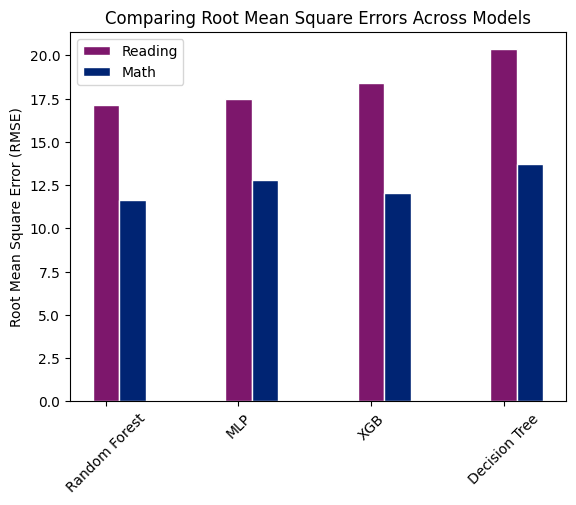

In [ ]:
# Plotting best results
import math
bar_width = 0.20
colors = ["#002473", "#0A85BA", "#ee9b00", "#7d176c"]
r1 = np.arange(len(reading_mses))
r2 = [x + bar_width for x in r1]
x_labels = ['Random Forest', 'MLP', 'XGB', 'Decision Tree']
reading_rmses =  [math.sqrt(val) for val in reading_mses]
math_rmses = [math.sqrt(val) for val in math_mses]
plt.title('Comparing Root Mean Square Errors Across Models')
plt.bar(r1, reading_rmses, color=colors[3], width=bar_width, edgecolor='white', label='Reading')
plt.bar(r2, math_rmses, color=colors[0], width=bar_width, edgecolor='white', label='Math')
plt.xticks(r1, x_labels, rotation=45)
plt.ylabel("Root Mean Square Error (RMSE)")
plt.legend()

In [ ]:
print(reading_rmses)

[17.146256194969343, 17.456679704791828, 18.38689635689562, 20.339524584996834]


In [ ]:
print(math_rmses)

[11.6574426867739, 12.799311034549643, 12.014136903664891, 13.690302698099947]


### Analyzing Feature Importance

In [ ]:
def plot_feature_importance(df, target_var, model, title, remove_other_scores = False):
    feature_names = list(df.columns.values)
    feature_names.remove(target_var)

    if remove_other_scores:
      feature_names = select_predictors(feature_names)

    print(len(feature_names))
    importances = model.feature_importances_
    print(len(importances))

    feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

    top_features = feature_importances.head(10)

    # Plot feature importances
    plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.bar(range(len(top_features)), top_features['Importance'], align="center")
    plt.xticks(range(len(top_features)), top_features['Feature'], rotation=45)
    plt.xlabel("Features")
    plt.ylabel("Importances")
    plt.tight_layout()
    plt.show()

442
442


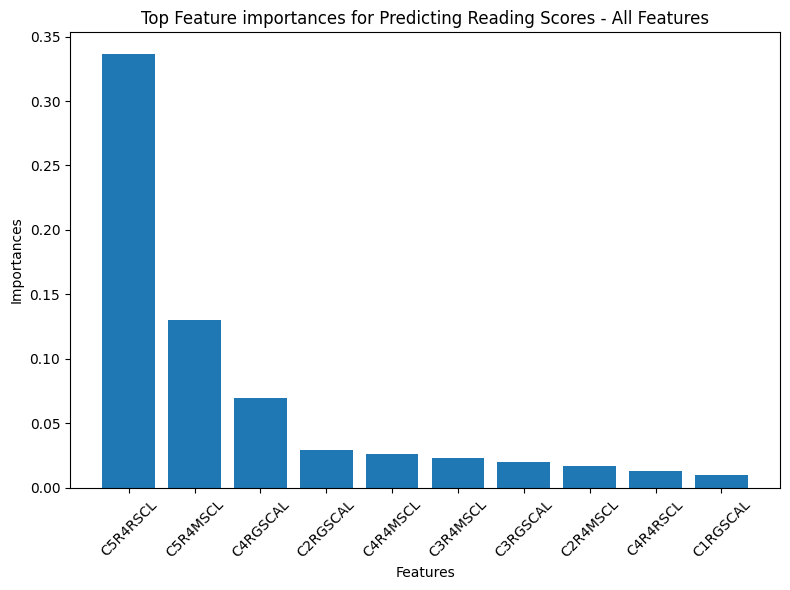

In [ ]:
plot_feature_importance(df_reading_reg, "C7R4RSCL", best_trained_models_reading[0], title = 'Top Feature importances for Predicting Reading Scores - All Features')

442
442


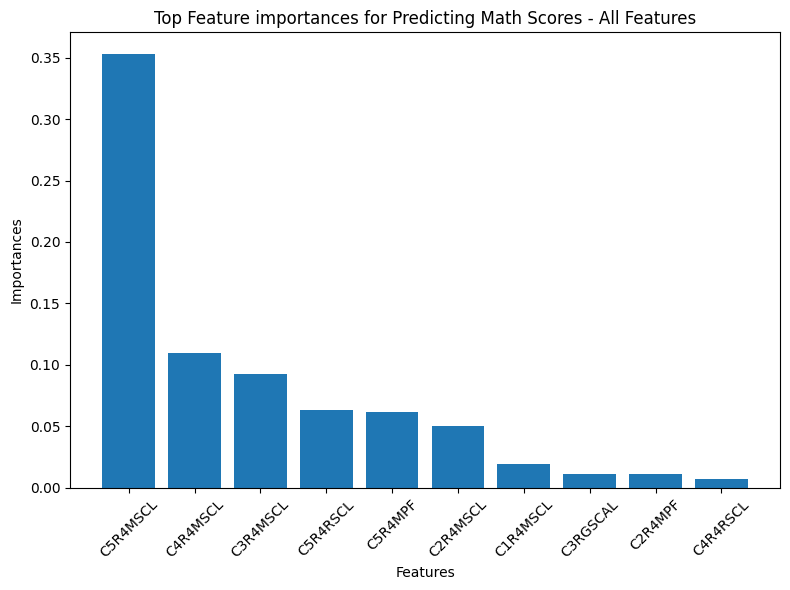

In [ ]:
plot_feature_importance(df_math_reg, "C7R4MSCL", best_trained_models_math[0], "Top Feature importances for Predicting Math Scores - All Features")

In [ ]:
train_and_eval_regression_model(df_reading_reg, "C7R4RSCL", best_rf_reading_reg, "reading_rf_filtered", select_from_model = True, max_features = 25)
train_and_eval_regression_model(df_math_reg, "C7R4MSCL", best_rf_math_reg, "math_rf_filtered", select_from_model = True, max_features = 25)

Num testing samples 547
Training R^2 Score: 0.9409781298672968
Test R^2 Score: 0.5305349071549211
Mean Squared Error (MSE): 319.3746
Num testing samples 547
Training R^2 Score: 0.955016411578977
Test R^2 Score: 0.6702533991230409
Mean Squared Error (MSE): 143.9697


(Pipeline(steps=[('feature_selection',
                  SelectFromModel(estimator=RandomForestRegressor(),
                                  max_features=25)),
                 ('regressor', RandomForestRegressor())]),
 143.96974114312656)

### Plotting Feature Importance Without Scores

Num testing samples 547
Training R^2 Score: 0.7651231700789973
Test R^2 Score: 0.32388588058837264
Mean Squared Error (MSE): 459.9568
376
376


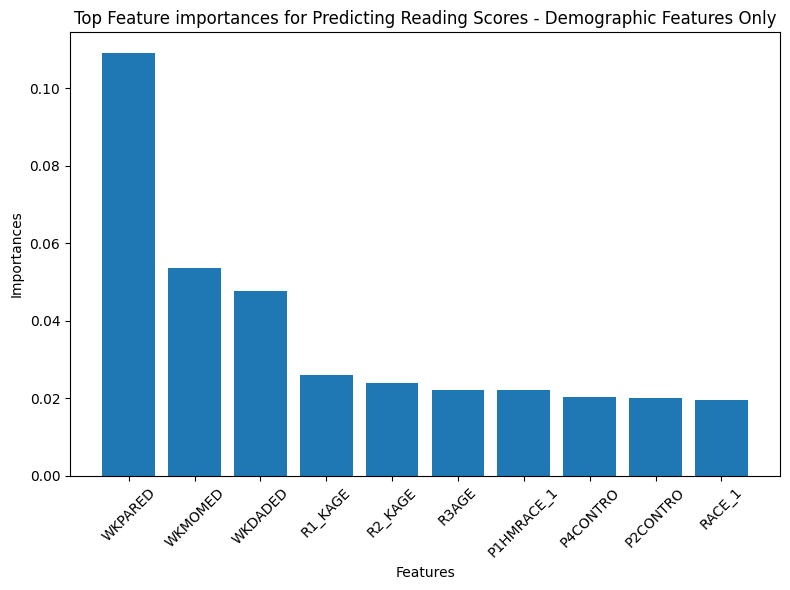

In [ ]:
best_rf_reading_reg_no_scores = RandomForestRegressor(max_depth = 80, max_features = 150, max_leaf_nodes= 120, min_samples_split= 10, n_estimators=100)
reading_no_scores_trained, mse = train_and_eval_regression_model(df_reading_reg, "C7R4RSCL", best_rf_reading_reg_no_scores, "reading_rf_no_scores", remove_other_scores = True)
plot_feature_importance(df_reading_reg, "C7R4RSCL", reading_no_scores_trained, "Top Feature importances for Predicting Reading Scores - Demographic Features Only", remove_other_scores = True)

Num testing samples 547
Training R^2 Score: 0.7067738067004703
Test R^2 Score: 0.30032842383764846
Mean Squared Error (MSE): 305.4816
376
376


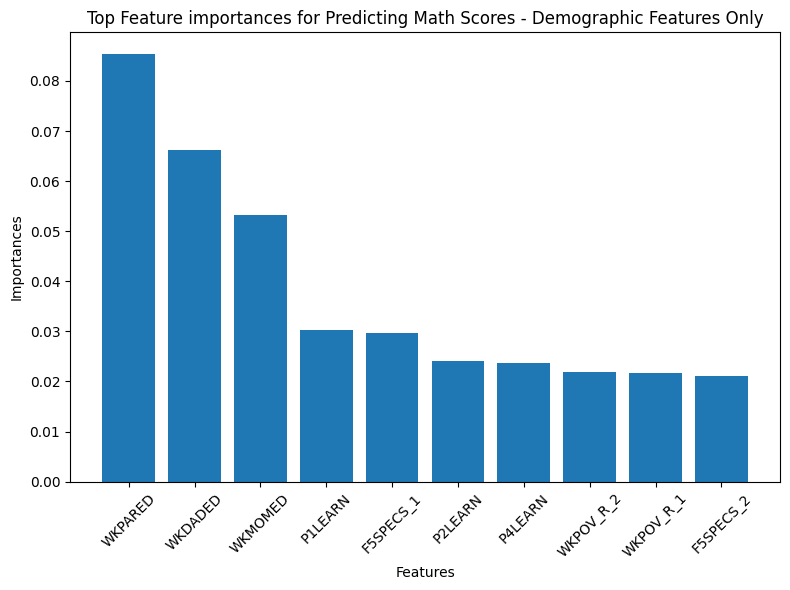

In [ ]:
best_rf_math_reg_no_scores = RandomForestRegressor(max_depth = 20, max_features = 150, max_leaf_nodes= 80, min_samples_split= 5, n_estimators=100)
math_no_scores_trained, mse = train_and_eval_regression_model(df_math_reg, "C7R4MSCL", best_rf_math_reg_no_scores, "math_rf_no_scores", remove_other_scores = True)
plot_feature_importance(df_math_reg, "C7R4MSCL", math_no_scores_trained, "Top Feature importances for Predicting Math Scores - Demographic Features Only", remove_other_scores = True)

### Plotting RMSE by race, gender for each model

In [ ]:
best_rf_reading_reg = RandomForestRegressor(max_depth = 80, max_features = 150, max_leaf_nodes= 120, min_samples_split= 10, n_estimators=100)
best_rf_math_reg = RandomForestRegressor(max_depth = 20, max_features = 150, max_leaf_nodes= 80, min_samples_split= 5, n_estimators=100)
df_reading_reg['RACE_HISP'] = df_reading_reg['RACE_3'] + df_reading_reg['RACE_4']
df_math_reg['RACE_HISP'] = df_math_reg['RACE_3'] + df_math_reg['RACE_4']
child_race_cols = ['RACE_1', 'RACE_2', 'RACE_HISP', 'RACE_5', 'RACE_6', 'RACE_7', 'RACE_8']
reading_mses_race = []
math_mses_race  = []
for col in child_race_cols:
    reading_model, reading_mse = train_and_eval_regression_model(df_reading_reg, "C7R4RSCL", best_rf_reading_reg, "reading_rf", attributes = {col: 1})
    reading_mses_race.append(reading_mse)
    math_model, math_mse = train_and_eval_regression_model(df_math_reg, "C7R4MSCL", best_rf_math_reg, "math_rf", attributes = {col: 1})
    math_mses_race.append(math_mse)

Only testing on those with attribute  RACE_1
Num testing samples 349
Training R^2 Score: 0.8853840469746195
Test R^2 Score: 0.43175454391231216
Mean Squared Error (MSE): 236.4265
Only testing on those with attribute  RACE_1
Num testing samples 349
Training R^2 Score: 0.8885429955124287
Test R^2 Score: 0.5901325004119595
Mean Squared Error (MSE): 105.3622
Only testing on those with attribute  RACE_2
Num testing samples 51
Training R^2 Score: 0.8875557060563151
Test R^2 Score: 0.4766958557393933
Mean Squared Error (MSE): 412.4771
Only testing on those with attribute  RACE_2
Num testing samples 51
Training R^2 Score: 0.8881623327662429
Test R^2 Score: 0.6364378158801689
Mean Squared Error (MSE): 184.3111
Only testing on those with attribute  RACE_HISP
Num testing samples 93
Training R^2 Score: 0.8869576343166136
Test R^2 Score: 0.4933702872657403
Mean Squared Error (MSE): 404.3714
Only testing on those with attribute  RACE_HISP
Num testing samples 93
Training R^2 Score: 0.8880729763206379

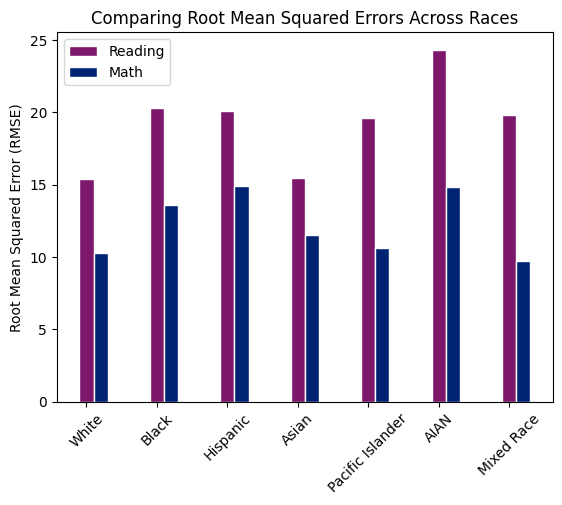

In [ ]:
 # Race Plot
import math
bar_width = 0.20
colors = ["#002473", "#0A85BA", "#ee9b00", "#7d176c"]
r1 = np.arange(len(reading_mses_race))
r2 = [x + bar_width for x in r1]
x_labels = ['White', 'Black', 'Hispanic', 'Asian', 'Pacific Islander', 'AIAN', 'Mixed Race']
reading_rmses_race =  [math.sqrt(val) for val in reading_mses_race]
math_rmses_race = [math.sqrt(val) for val in math_mses_race]
plt.title('Comparing Root Mean Squared Errors Across Races')
plt.bar(r1, reading_rmses_race, color=colors[3], width=bar_width, edgecolor='white', label='Reading')
plt.bar(r2, math_rmses_race, color=colors[0], width=bar_width, edgecolor='white', label='Math')
plt.xticks(r1, x_labels, rotation=45)
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.legend()

In [ ]:
child_race_cols = ['GENDER_1', 'GENDER_2']
reading_mses_gender = []
math_mses_gender = []
for col in child_race_cols:
    reading_model, reading_mse = train_and_eval_regression_model(df_reading_reg, "C7R4RSCL", best_rf_reading_reg, "reading_rf", attributes = {col: 1})
    reading_mses_gender.append(reading_mse)
    math_model, math_mse = train_and_eval_regression_model(df_math_reg, "C7R4MSCL", best_rf_math_reg, "math_rf", attributes = {col: 1})
    math_mses_gender.append(math_mse)

Only testing on those with attribute  GENDER_1
Num testing samples 258
Training R^2 Score: 0.886701418827318
Test R^2 Score: 0.5455240958206871
Mean Squared Error (MSE): 350.4985
Only testing on those with attribute  GENDER_1
Num testing samples 258
Training R^2 Score: 0.8877212636044322
Test R^2 Score: 0.6536606377592145
Mean Squared Error (MSE): 136.1291
Only testing on those with attribute  GENDER_2
Num testing samples 289
Training R^2 Score: 0.8879852177279273
Test R^2 Score: 0.5854390776166897
Mean Squared Error (MSE): 247.2209
Only testing on those with attribute  GENDER_2
Num testing samples 289
Training R^2 Score: 0.8886862627530681
Test R^2 Score: 0.699665370605204
Mean Squared Error (MSE): 140.3577


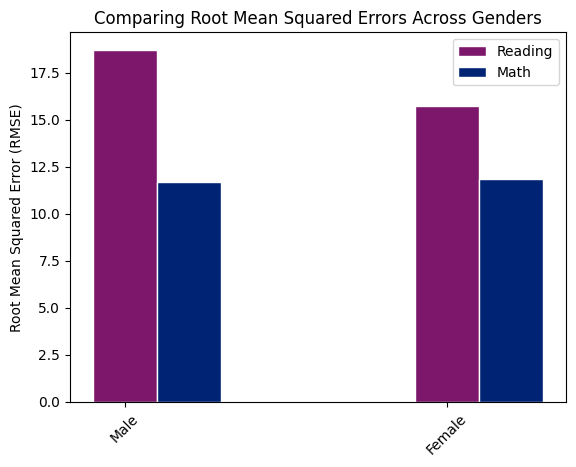

In [ ]:
 # Gender Plot
import math
bar_width = 0.20
colors = ["#002473", "#0A85BA", "#ee9b00", "#7d176c"]
r1 = np.arange(len(reading_mses_gender))
r2 = [x + bar_width for x in r1]
x_labels = ['Male', 'Female']
reading_rmses_gender =  [math.sqrt(val) for val in reading_mses_gender]
math_rmses_gender = [math.sqrt(val) for val in math_mses_gender]
plt.bar(r1, reading_rmses_gender, color=colors[3], width=bar_width, edgecolor='white', label='Reading')
plt.bar(r2, math_rmses_gender, color=colors[0], width=bar_width, edgecolor='white', label='Math')
plt.xticks(r1, x_labels, rotation=45)
plt.title('Comparing Root Mean Squared Errors Across Genders')
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.legend()

###Fairness After Removing Protected Attributes


In [ ]:
def train_and_eval_regression_model(df, target_var, model, model_name, cols_to_remove = [], attributes = {}, select_from_model = False, max_features = 100):
    # "independent" variables
    feature_cols = list(df.columns.values)
    feature_cols.remove(target_var)

    X = df[feature_cols] # Features
    y = df[target_var] # Target variable

    # Split dataset into training set and test set
    # 70% training and 30% test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

    for attribute in attributes:
        y_test = y_test[X_test[attribute] == attributes[attribute]]
        X_test = X_test[X_test[attribute] == attributes[attribute]]
        print('Only testing on those with attribute ', attribute)
    # print('Num features before', X_test.shape[1])

    for col in X_test.columns:
        if any(var in col for var in cols_to_remove):
            X_test = X_test.drop(columns=[col])
            X_train = X_train.drop(columns=[col])

    # print('Num features after', X_test.shape[1])
    print('Num testing samples', len(y_test))

    if select_from_model:
        model = Pipeline([
        ('feature_selection', SelectFromModel(RandomForestRegressor(), max_features = max_features)),
        ('regressor', RandomForestRegressor())
        ])

    reg = model.fit(X_train, y_train)
    y_pred = reg.predict(X_test)

    # compare training and test accuracy
    print("Training R^2 Score: " + str(model.score(X_train, y_train)))
    print("Test R^2 Score: " + str(model.score(X_test, y_test)))

    # Calculate the Mean Squared Error
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error (MSE): {mse:.4f}")

    # save model
    pickle.dump(model, open(model_name + '_model.sav', 'wb'))

    return model, mse

In [ ]:
cols_to_remove = ['RACE', 'GENDER', 'CS_TYPE2', 'P1HMAGE', 'P1HDAGE', "HISP", "IND",
               "ASN", "BLCK", "PACI", "WHT", "MT1R"]


In [ ]:
df_reading_reg['RACE_HISP'] = df_reading_reg['RACE_3'] + df_reading_reg['RACE_4']
df_math_reg['RACE_HISP'] = df_math_reg['RACE_3'] + df_math_reg['RACE_4']
child_race_cols = ['RACE_1', 'RACE_2', 'RACE_HISP', 'RACE_5', 'RACE_6', 'RACE_7', 'RACE_8']
reading_mses_race = []
math_mses_race  = []
for col in child_race_cols:
    reading_model, reading_mse = train_and_eval_regression_model(df_reading_reg, "C7R4RSCL", best_rf_reading_reg, "reading_rf", cols_to_remove = cols_to_remove, attributes = {col: 1})
    reading_mses_race.append(reading_mse)
    math_model, math_mse = train_and_eval_regression_model(df_math_reg, "C7R4MSCL", best_rf_math_reg, "math_rf", cols_to_remove = cols_to_remove, attributes = {col: 1})
    math_mses_race.append(math_mse)

Only testing on those with attribute  RACE_1
Num testing samples 349
Training R^2 Score: 0.8881896754215725
Test R^2 Score: 0.43770869608831275
Mean Squared Error (MSE): 233.9492
Only testing on those with attribute  RACE_1
Num testing samples 349
Training R^2 Score: 0.8899067661453883
Test R^2 Score: 0.5790926970214672
Mean Squared Error (MSE): 108.2001
Only testing on those with attribute  RACE_2
Num testing samples 51
Training R^2 Score: 0.886600073542065
Test R^2 Score: 0.4822312878180778
Mean Squared Error (MSE): 408.1140
Only testing on those with attribute  RACE_2
Num testing samples 51
Training R^2 Score: 0.8899343067772099
Test R^2 Score: 0.632900925253251
Mean Squared Error (MSE): 186.1042
Only testing on those with attribute  RACE_HISP
Num testing samples 93
Training R^2 Score: 0.8866632469746883
Test R^2 Score: 0.48951416090915845
Mean Squared Error (MSE): 407.4492
Only testing on those with attribute  RACE_HISP
Num testing samples 93
Training R^2 Score: 0.8904251771804021


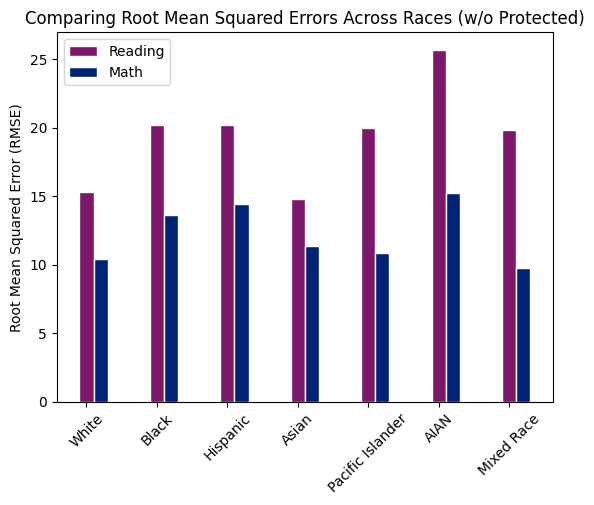

In [ ]:
# Race Plot
import math
bar_width = 0.20
colors = ["#002473", "#0A85BA", "#ee9b00", "#7d176c"]
r1 = np.arange(len(reading_mses_race))
r2 = [x + bar_width for x in r1]
x_labels = ['White', 'Black', 'Hispanic', 'Asian', 'Pacific Islander', 'AIAN', 'Mixed Race']
reading_rmses =  [math.sqrt(val) for val in reading_mses_race]
math_rmses = [math.sqrt(val) for val in math_mses_race]
plt.title('Comparing Root Mean Squared Errors Across Races (w/o Protected)')
plt.bar(r1, reading_rmses, color=colors[3], width=bar_width, edgecolor='white', label='Reading')
plt.bar(r2, math_rmses, color=colors[0], width=bar_width, edgecolor='white', label='Math')
plt.xticks(r1, x_labels, rotation=45)
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.legend()

In [ ]:
child_race_cols = ['GENDER_1', 'GENDER_2']
reading_mses_gender = []
math_mses_gender = []
for col in child_race_cols:
    reading_model, reading_mse = train_and_eval_regression_model(df_reading_reg, "C7R4RSCL", best_rf_reading_reg, "reading_rf", cols_to_remove = cols_to_remove, attributes = {col: 1})
    reading_mses_gender.append(reading_mse)
    math_model, math_mse = train_and_eval_regression_model(df_math_reg, "C7R4MSCL", best_rf_math_reg, "math_rf", cols_to_remove = cols_to_remove, attributes = {col: 1})
    math_mses_gender.append(math_mse)

Only testing on those with attribute  GENDER_1
Num testing samples 258
Training R^2 Score: 0.8883848492519737
Test R^2 Score: 0.5547828260144423
Mean Squared Error (MSE): 343.3581
Only testing on those with attribute  GENDER_1
Num testing samples 258
Training R^2 Score: 0.8910546932114443
Test R^2 Score: 0.6552241784185575
Mean Squared Error (MSE): 135.5145
Only testing on those with attribute  GENDER_2
Num testing samples 289
Training R^2 Score: 0.8879109981873176
Test R^2 Score: 0.5683839634001724
Mean Squared Error (MSE): 257.3916
Only testing on those with attribute  GENDER_2
Num testing samples 289
Training R^2 Score: 0.8917043445894264
Test R^2 Score: 0.7106397304437226
Mean Squared Error (MSE): 135.2290


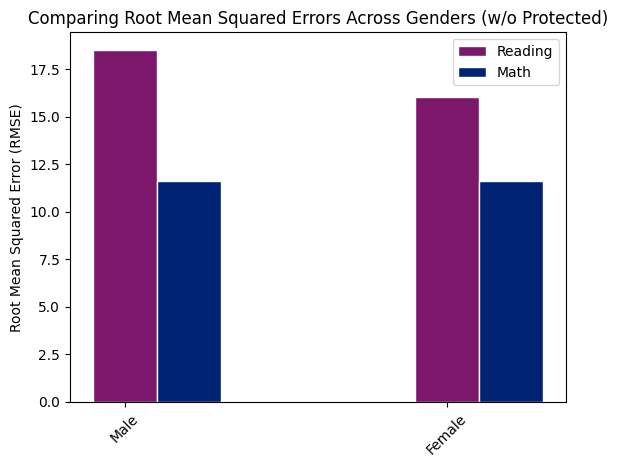

In [ ]:
 # Gender Plot
import math
bar_width = 0.20
colors = ["#002473", "#0A85BA", "#ee9b00", "#7d176c"]
r1 = np.arange(len(reading_mses_gender))
r2 = [x + bar_width for x in r1]
x_labels = ['Male', 'Female']
reading_rmses =  [math.sqrt(val) for val in reading_mses_gender]
math_rmses = [math.sqrt(val) for val in math_mses_gender]
plt.bar(r1, reading_rmses, color=colors[3], width=bar_width, edgecolor='white', label='Reading')
plt.bar(r2, math_rmses, color=colors[0], width=bar_width, edgecolor='white', label='Math')
plt.xticks(r1, x_labels, rotation=45)
plt.title('Comparing Root Mean Squared Errors Across Genders (w/o Protected)')
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.legend()